# Sentiment Analysis on Amazon Reviews dataset 2023

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
# Read in data
Appliance_subset_df = pd.read_parquet('..\Project Main\data\Appliance_file_subset.parquet', engine='pyarrow')

In [5]:
Appliance_subset_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,1619039933066,0,True
1,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,1485195813000,0,True
2,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,AGIOHNK7IWRDNBWYPGETIDTKTJUA,1505914496902,0,True
3,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,1605903535168,0,True
4,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,1645229528359,0,True


In [6]:
print(Appliance_subset_df.shape)

(50000, 10)


In [7]:
Appliance_subset_df['rating'].value_counts().sort_index()

rating
1.0     5918
2.0     1871
3.0     2421
4.0     5024
5.0    34766
Name: count, dtype: int64

## Quick EDA

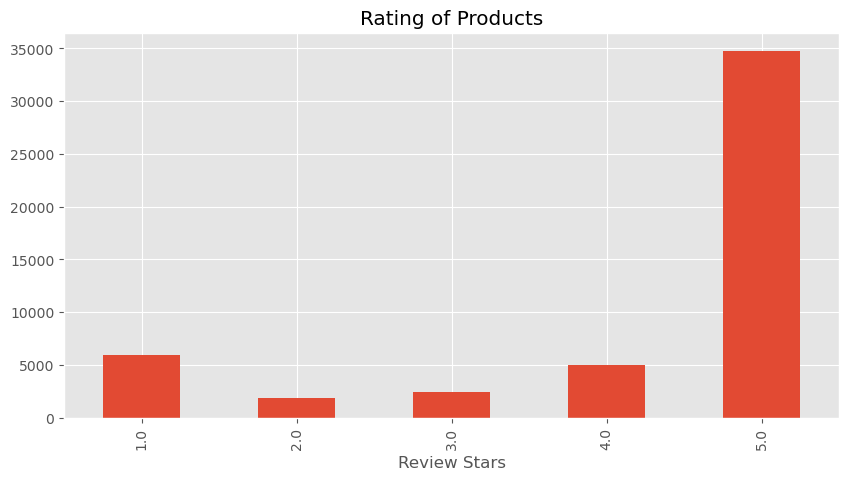

In [8]:
rating = Appliance_subset_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Rating of Products',
          figsize=(10, 5))
rating.set_xlabel('Review Stars')
plt.show()

## NLTK

In [9]:
example = Appliance_subset_df['text'][1989]
print(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


In [10]:
tokens = nltk.word_tokenize(example)
tokens[:]

['Easy',
 'Replacement',
 'Parts',
 'for',
 'Appliances',
 'at',
 'a',
 'Reduced',
 'Price',
 'and',
 'fits',
 'perfect',
 '...']

In [11]:
#part of speech tagging values
tagged = nltk.pos_tag(tokens)
tagged[:]

[('Easy', 'JJ'),
 ('Replacement', 'NNP'),
 ('Parts', 'NNP'),
 ('for', 'IN'),
 ('Appliances', 'NNP'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('Reduced', 'NNP'),
 ('Price', 'NNP'),
 ('and', 'CC'),
 ('fits', 'NNS'),
 ('perfect', 'VBP'),
 ('...', ':')]

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
#prettyprint

(S
  (PERSON Easy/JJ)
  (ORGANIZATION Replacement/NNP Parts/NNP)
  for/IN
  Appliances/NNP
  at/IN
  a/DT
  (ORGANIZATION Reduced/NNP)
  Price/NNP
  and/CC
  fits/NNS
  perfect/VBP
  .../:)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [14]:
sia

In [15]:
sia.polarity_scores("It was a complete waste of time")

{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.4215}

In [16]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [17]:
sia.polarity_scores("Fits perfect")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [18]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect')

{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.765}

In [19]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...')

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

interesting

Should be more positive than that

In [20]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    opinion = row['text']
    id = row['user_id']
    results[id] = sia.polarity_scores(opinion)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [21]:
results

{'AFJBSFUSBCMWLLXMBZ44ETHRKNOA': {'neg': 0.072,
  'neu': 0.809,
  'pos': 0.118,
  'compound': 0.3818},
 'AGB653QU2TLQPUZ2QX3VNRWFOUKQ': {'neg': 0.0,
  'neu': 0.0,
  'pos': 1.0,
  'compound': 0.6588},
 'AGIOHNK7IWRDNBWYPGETIDTKTJUA': {'neg': 0.0,
  'neu': 0.391,
  'pos': 0.609,
  'compound': 0.7774},
 'AGBTZVKIXMEBARPSYPIQLFH2NYWQ': {'neg': 0.0,
  'neu': 0.58,
  'pos': 0.42,
  'compound': 0.7003},
 'AHKS2IQWTIFWQZTUVP23U2GYLO5Q': {'neg': 0.0,
  'neu': 0.377,
  'pos': 0.623,
  'compound': 0.765},
 'AHY557OHZXZUGKRAB6ZHRONRE26A': {'neg': 0.0,
  'neu': 0.671,
  'pos': 0.329,
  'compound': 0.6597},
 'AGOICXX54S3SREXAOM3BYYN4AZRA': {'neg': 0.082,
  'neu': 0.918,
  'pos': 0.0,
  'compound': -0.395},
 'AHO74DWEGRT3UVGRKG4CCOMTL5BA': {'neg': 0.0,
  'neu': 0.734,
  'pos': 0.266,
  'compound': 0.4404},
 'AH7AGJZSWT5KAEW4OFJIH5DQCUUA': {'neg': 0.042,
  'neu': 0.863,
  'pos': 0.096,
  'compound': 0.9699},
 'AFMZ3YXI2VANHHEXF2LCBCYHFEGA': {'neg': 0.043,
  'neu': 0.803,
  'pos': 0.154,
  'compound': 

In [22]:
vaders = pd.DataFrame(results).T
vaders.head()

,neg,neu,pos,compound
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [23]:
vaders.index.name = 'user_id'
vaders.head()

,neg,neu,pos,compound
user_id,,,,
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [24]:
# Reset the index to turn the index into a column
vaders = vaders.reset_index()
vaders.head()


,user_id,neg,neu,pos,compound
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [25]:
vaders = vaders.merge(Appliance_subset_df, how='inner')

In [26]:
# Now we have sentiment score and metadata
vaders.head()

,user_id,neg,neu,pos,compound,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,1619039933066,0,True
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,1485195813000,0,True
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,1505914496902,0,True
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,1605903535168,0,True
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,1645229528359,0,True


## Plot VADER results

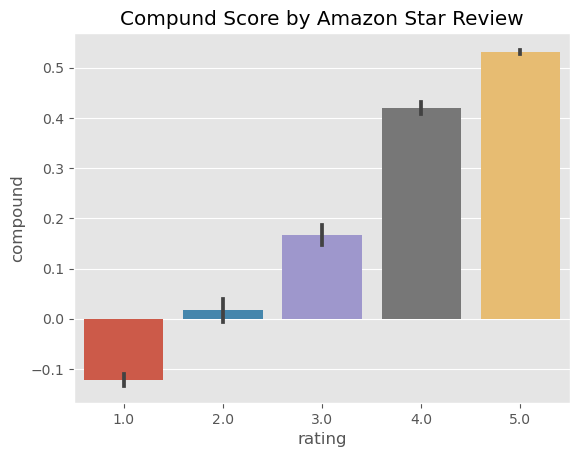

In [27]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

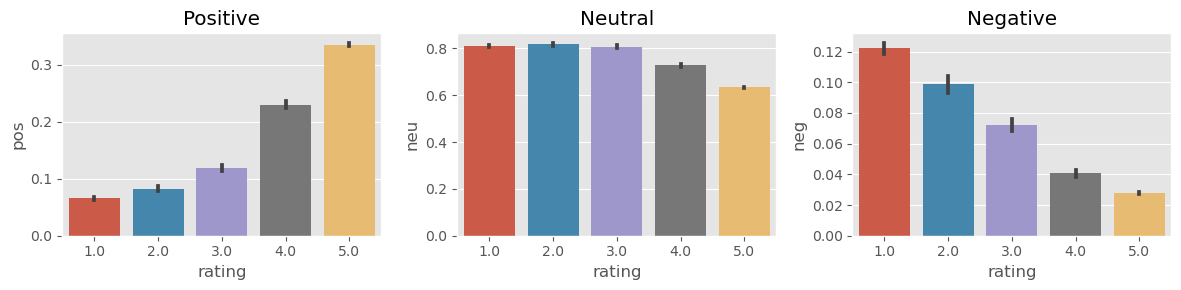

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

next step Install PyTorch

In [29]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [30]:
#pull in a model provided by hugging face pre-trained on a large twitter dataset 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\gisi_\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
# Remembering VADER results on example
print(example)
sia.polarity_scores(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [32]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.003501815, 'roberta_neu': 0.095212415, 'roberta_pos': 0.90128577}


In [33]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [34]:
df = Appliance_subset_df.sample(5000)

In [35]:
df.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
31745,5.0,Five Stars,worked well,[],B0041OMP86,B00PRA4C70,AEB67UVHDPE4DDDPD66WYB27PKHA,1446221407000,0,True
49865,5.0,It works well as it slightly larger than the p...,It works well as it slightly larger than the p...,[],B001S353EQ,B0BLKB8WR3,AF3TNVKAJNLP2CWDLBKQF5UDN7AA,1396372976000,0,True


In [36]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        
        
        text = row['text']
        id = row['user_id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id AGXMFNQWLTFJFZIQS4ORUXCMFTLQ
Broke for id AESFYAMYCMZJKJZV6L233RTM2KXQ
Broke for id AH7AGJZSWT5KAEW4OFJIH5DQCUUA
Broke for id AHOY6J4YH62HKWR7CJX2HTGOOCCQ
Broke for id AF2PCMA6BNQLS75YTXQTNSYQHDAA
Broke for id AE72CVOI3H57OQMIFXHKOZTIC7IQ
Broke for id AHBOMGFP5PDU3LEUVNEYYC6JWFMQ
Broke for id AFWQJPMPWMP2EFELF24P4DTVZRCA
Broke for id AGNN3UUCIF34XRXRO2UGL46AFGBA
Broke for id AGUQJZHE662GL4MY2GLBMA4HZ3IQ


In [42]:
results_df = pd.DataFrame(res).T
# results_df = results_df.reset_index().rename(columns={'index': 'Id'})
# results_df = results_df.merge(df, how='left')

In [43]:
#results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df.head(2)

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
AEB67UVHDPE4DDDPD66WYB27PKHA,0.0,0.323,0.677,0.2732,0.012794,0.284816,0.702390
AF3TNVKAJNLP2CWDLBKQF5UDN7AA,0.0,0.658,0.342,0.8074,0.001394,0.020533,0.978073


In [45]:
results_df = results_df.merge(df, how='inner')

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

## Compare Scores between models

In [46]:
results_df.columns

Index(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3. Combine and compare

KeyError: 'Score'

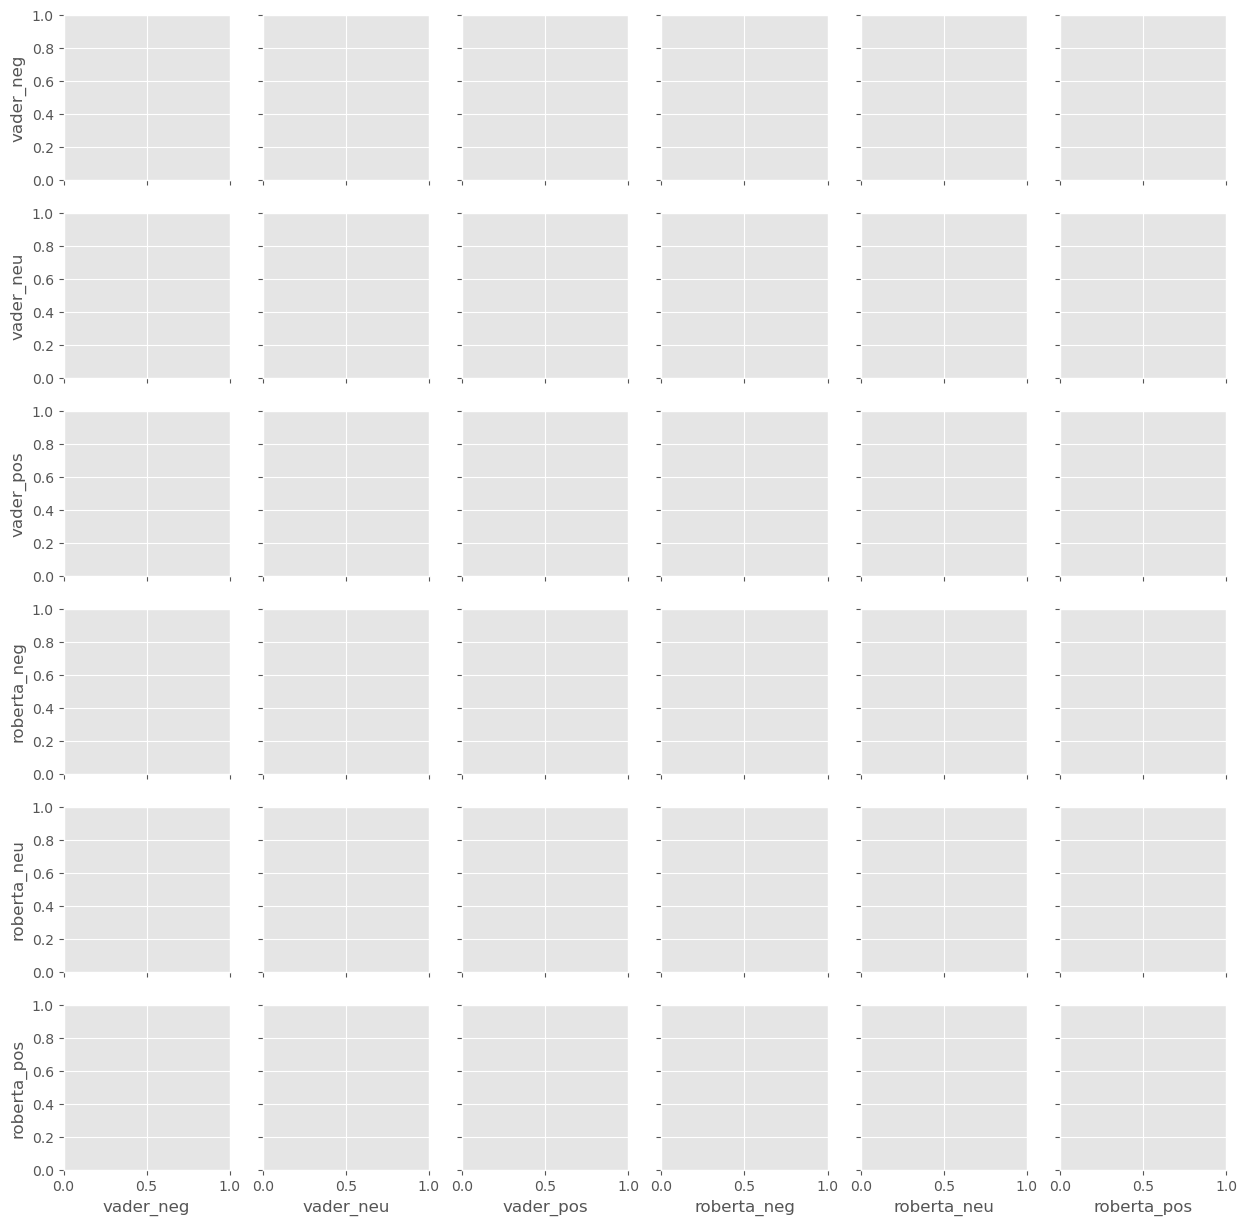

In [47]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [29]:
# negative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# __